In [65]:
import json
from math import ceil
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

RESULTS_FOLDER = '../results'
SUBSETS = ['train_cnn', 'val', 'train_rnn', 'test']
FOLDS = [str(fold) for fold in range(1, 11)]
BEST_MODELS = [
    ('hp_pr', '29'),
    ('hp_po', '63'),
    ('hp_tf', '5'),
    ('hp_cr', '56'),
    ('hp_sh', '66'),
    ('hp_ro', '14'),
]

def get_metrics(exp_name, model_id):
    metrics_path = join(
        RESULTS_FOLDER, exp_name, f'model_{model_id}', 'metrics.json'
    )
    with open(metrics_path, 'r') as metrics_json:
        metrics_file = json.load(metrics_json)

    return metrics_file['metrics']

def n_bins(values):
    sorted_values = sorted(values)
    length = len(sorted_values)
    q1 = ceil(length / 4)
    q3 = ceil(length * 3 / 4)
    IQR = sorted_values[q3 - 1] - sorted_values[q1 - 1]
    h = 2 * IQR * (length ** (-1/3))
    max_value = values[-1]
    min_value = values[0]
    return ceil((max_value - min_value) / h)

In [3]:
model_metrics = get_metrics('hp_tf', '5')

In [4]:
model_metrics['1']['test']['33_PDNRKIBC'].keys()

dict_keys(['f1', 'rec', 'fp', 'pre', 'fn', 'acc', 'total', 'tp', 'tn', 'real', 'pred'])

In [40]:
def generate_model_f1_scores(model_type, model_id):
    model_metrics = get_metrics(model_type, model_id)
    f1_scores = [
        {
            'pb_name': pb_name,
            'f1': model_metrics[fold]['test'][pb_name]['f1'],
        }
        for fold in FOLDS
        for pb_name in model_metrics[fold]['test'].keys()

    ]
    f1_scores.sort(key=lambda item: item['f1'])
    return [item['f1'] for item in f1_scores]

In [5]:
f1_scores = [
    {
        'pb_name': pb_name,
        'f1': model_metrics[fold]['test'][pb_name]['f1'],
    }
    for fold in FOLDS
    for pb_name in model_metrics[fold]['test'].keys()
    
]
f1_scores.sort(key=lambda item: item['f1'])

In [6]:
def display_scores(scores):
    for score in scores:
        print(f'{score["pb_name"]} & ${score["f1"]:.2f}$ \\\\')

### Peores

In [7]:
display_scores(f1_scores[:5])

20_PD6M9KHG & $0.00$ \\
64_PDJJP4QL & $0.00$ \\
01_PD796ARA & $0.00$ \\
48_PDKS3P67 & $0.00$ \\
43_PDQWC1XR & $0.00$ \\


### Intermedios

In [46]:
display_scores(f1_scores[38:43])

38_PDRNCFK4 & $0.69$ \\
12_PDMAXIGK & $0.70$ \\
19_PDSTFKAK & $0.71$ \\
79_PD9S31N6 & $0.72$ \\
46_PD2DK5KB & $0.74$ \\


### Mejores

In [47]:
display_scores(f1_scores[-5:])

13_PD2SW1EO & $1.00$ \\
69_PDNVGH7Z & $1.00$ \\
65_PDY5C128 & $1.00$ \\
15_PDX94EF7 & $1.00$ \\
70_PDUPMC2M & $1.00$ \\


In [97]:
def setup_plot(axis, model, f1_scores, show_x_label, show_y_label):
    axis.grid(axis='y')
    axis.set_axisbelow(True)
    if show_x_label: axis.set_xlabel('F1 Score')
    if show_y_label: axis.set_ylabel('# Pullbacks')
    axis.set_ylim(0, 33)
    axis.set_title(f'{model[0][-2:]}-{model[1]}'.upper())
    axis.hist(f1_scores, bins=n_bins(f1_scores))

In [45]:
def generate_all_f1_scores():
    for model in BEST_MODELS:
        yield model, generate_model_f1_scores(*model)

In [92]:
def should_show_labels(row_index, col_index):
    if col_index == 0 and row_index == 2:
        return (True, True)
    if row_index == 2:
        return (True, False)
    if col_index == 0:
        return (False, True)
    return (False, False)

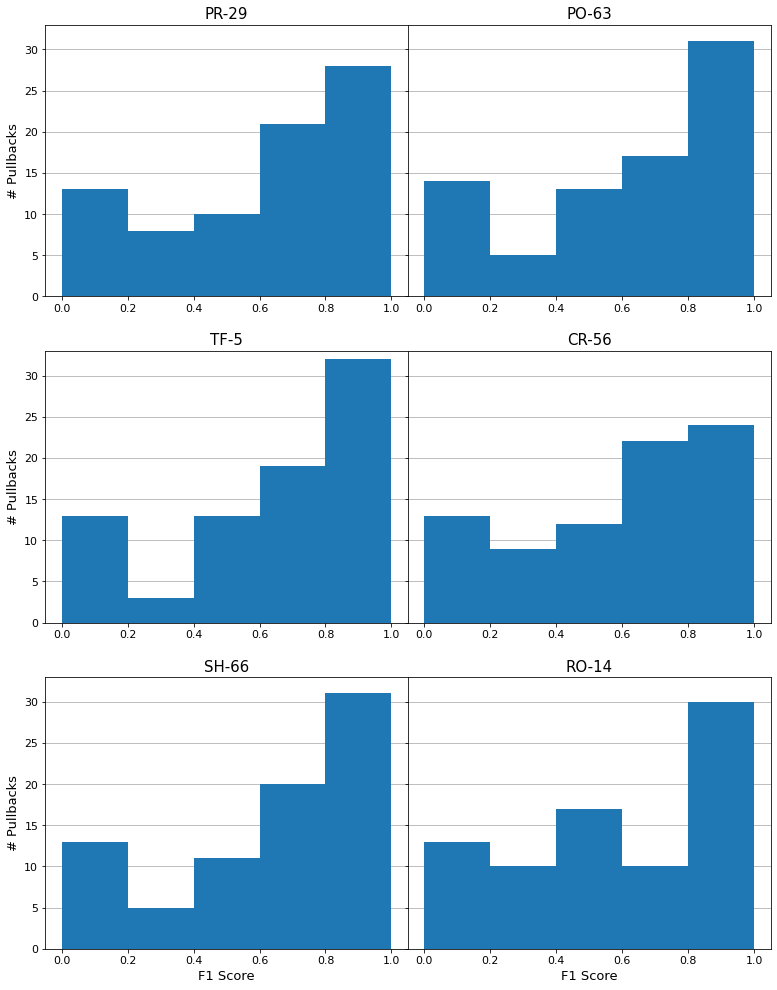

In [110]:
plt.rc('axes', labelsize=13, titlesize=15)
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(13, 17))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0)
axises = gs.subplots(sharey='row')
all_f1_scores = generate_all_f1_scores()

for row_index, row in enumerate(axises):
    for col_index, axis in enumerate(row):
        model, f1_scores = next(all_f1_scores)
        show_x_label, show_y_label = should_show_labels(row_index, col_index)
        setup_plot(axis, model, f1_scores, show_x_label, show_y_label)

[None, Text(0.5, 0, 'Modelo'), Text(0, 0.5, 'F1 Score')]

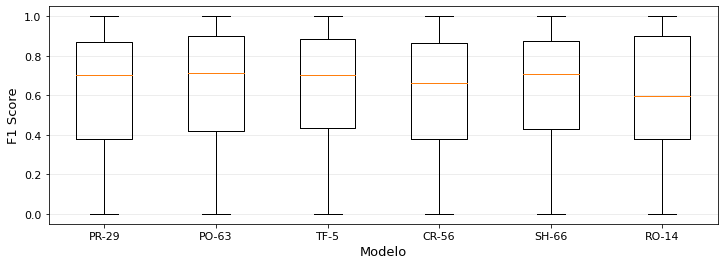

In [130]:
plt.rc('axes', labelsize=13, titlesize=15)
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0)
axis = gs.subplots(sharey='row')

labels = [f'{model_type[-2:]}-{model_id}'.upper() for model_type, model_id in BEST_MODELS]

axis.boxplot([scores for model, scores in generate_all_f1_scores()], labels=labels)

axis.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axis.set(
    axisbelow=True,
    xlabel='Modelo',
    ylabel='F1 Score',
)